<a href="https://colab.research.google.com/github/PDNow-Research/PDNow/blob/main/HandPD/LogReg_88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Data Science
import re
import csv
import json
import itertools
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import interp
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc

# General
import os
import sys
import time
import math
import random
from datetime import date
import warnings
current_date = date.today()
warnings.filterwarnings("ignore")

# SVM
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, average_precision_score, classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold, KFold


Here's the plan. 

To train the model, we're going to combine a BUNCH of data. Data from Meander && Spiral from Old Hand PD and New Hand PD. Just to see how it goes. Then we'll try more detailed extraction.

Also, try only on new with age?

Run simple SVM based on output of neural network model and age and some other stats :)

CAN POSSIBLY: just extract 5 PD patients and 5 control patients for testing from new hand pd set and just train on everything else. That should be fine...... Then ez to test, just pass those in and evaluate results per patient, perhaps reach 90% accuracy with this 

We also do cross validation/validation set? then.

also, hyperparameter tuning? Can get above 90% accuracy maybe with that!

Discuss more with TT

### Extracting from Old Hand PD

In [3]:
spiral_df = pd.read_csv('/content/drive/My Drive/Data/HandPD-Replication/Spiral_HandPD.txt', delimiter=' ', index_col=0, names=['Image', 'Label', 'RMS', 'Max_dist', 'Min_dist', 'SD', 'MRT', 'Max_ET', 'Min_ET', 'SD_ET', 'HT_ET_Diff'])

In [4]:
spiral_df.shape

(368, 10)

In [5]:
spiral_df['Label'].value_counts()

2    296
1     72
Name: Label, dtype: int64

In [6]:
spiral_df.dtypes

Label           int64
RMS           float64
Max_dist      float64
Min_dist      float64
SD            float64
MRT           float64
Max_ET        float64
Min_ET        float64
SD_ET         float64
HT_ET_Diff    float64
dtype: object

In [7]:
# extracting necessary columns from spiral df
X_spiral = spiral_df[['RMS', 'Max_dist', 'Min_dist', 'SD', 'MRT', 'Max_ET', 'Min_ET', 'SD_ET', 'HT_ET_Diff']]
y_spiral = spiral_df['Label']

y_spiral = pd.DataFrame(y_spiral)

In [8]:
meander_df = pd.read_csv('/content/drive/My Drive/Data/HandPD-Replication/Meander_HandPD.txt', delimiter=' ', index_col=0, names=['Image', 'Label', 'RMS', 'Max_dist', 'Min_dist', 'SD', 'MRT', 'Max_ET', 'Min_ET', 'SD_ET', 'HT_ET_Diff'])

In [9]:
meander_df.shape

(368, 10)

In [10]:
spiral_df['Label'].value_counts()

2    296
1     72
Name: Label, dtype: int64

In [11]:
# choosing all patients from meander_df
X_meander = meander_df[['RMS', 'Max_dist', 'Min_dist', 'SD', 'MRT', 'Max_ET', 'Min_ET', 'SD_ET', 'HT_ET_Diff']]

y_meander = meander_df['Label']
y_meander = pd.DataFrame(y_meander)

In [12]:
index_list = y_meander.index[y_meander['Label'] == 2].tolist()

In [13]:
len(index_list)

296

In [14]:
import random 

def delete_random_elems(input_list, n):
    to_delete = set(random.sample(range(len(input_list)), n))
    return [x for i,x in enumerate(input_list) if not i in to_delete]

In [15]:
new_list = delete_random_elems(index_list, 256)

In [16]:
len(new_list)

40

In [17]:
X_meander = X_meander.drop(new_list)
y_meander = y_meander.drop(new_list)

### Extracting from New HandPD

In [18]:
new_spiral_df = pd.read_csv('/content/drive/My Drive/Data/HandPD-Replication/NewSpiral.csv', skiprows = 1, index_col = 0, names=['ID_EXAM', 'Image', 'ID_PATIENT', 'Label', 'GENDER', 'HANDEDNESS', 'AGE', 'RMS', 'Max_dist', 'Min_dist', 'SD', 'MRT', 'Max_ET', 'Min_ET', 'SD_ET', 'HT_ET_Diff']) # skiprows to remove first row of old columns names

In [19]:
new_spiral_df.columns

Index(['Image', 'ID_PATIENT', 'Label', 'GENDER', 'HANDEDNESS', 'AGE', 'RMS',
       'Max_dist', 'Min_dist', 'SD', 'MRT', 'Max_ET', 'Min_ET', 'SD_ET',
       'HT_ET_Diff'],
      dtype='object')

In [20]:
# choosing only control from new spiral_df
X_new_spiral = new_spiral_df [new_spiral_df["Label"] == 1]
X_new_spiral = X_new_spiral[['RMS', 'Max_dist', 'Min_dist', 'SD', 'MRT', 'Max_ET', 'Min_ET', 'SD_ET', 'HT_ET_Diff']]

y_new_spiral = new_spiral_df [new_spiral_df["Label"] == 1]
y_new_spiral = y_new_spiral['Label']

y_new_spiral = pd.DataFrame(y_new_spiral)

In [21]:
y_new_spiral.value_counts()

Label
1        140
dtype: int64

In [22]:
new_meander_df = pd.read_csv('/content/drive/My Drive/Data/HandPD-Replication/NewMeander.csv', index_col = 0, skiprows =1, names=['ID_EXAM', 'Image', 'ID_PATIENT', 'Label', 'GENDER', 'HANDEDNESS', 'AGE', 'RMS', 'Max_dist', 'Min_dist', 'SD', 'MRT', 'Max_ET', 'Min_ET', 'SD_ET', 'HT_ET_Diff'])

In [23]:
# choosing only control from new meander_df
X_new_meander = new_meander_df [new_meander_df["Label"] == 1]
X_new_meander = X_new_meander[['RMS', 'Max_dist', 'Min_dist', 'SD', 'MRT', 'Max_ET', 'Min_ET', 'SD_ET', 'HT_ET_Diff']]

y_new_meander = new_meander_df [new_meander_df["Label"] == 1]
y_new_meander = y_new_meander['Label']

y_new_meander = pd.DataFrame(y_new_meander)

In [24]:
y_new_meander.value_counts()

Label
1        140
dtype: int64

##**Preprocessing**

###**Normalization**

fi' = (fi - avg)/std

In [25]:
# normalization with the paper's method (formula above)
def feature_normalization(df):
  avg_dev = df.mad(axis = 0)
  std_dev = df.std(axis = 0)

  df = df.sub(avg_dev)
  df = df.divide(std_dev)

  return df

In [26]:
# normalize separately

X_spiral = feature_normalization(X_spiral)
X_new_spiral = feature_normalization(X_new_spiral)

X_meander = feature_normalization(X_meander)
X_new_meander = feature_normalization(X_new_meander)

In [27]:
X = pd.concat([X_spiral, X_new_spiral, X_meander,  X_new_meander])
y = pd.concat([y_spiral, y_new_spiral, y_meander,  y_new_meander])

In [28]:
X.shape

(976, 9)

In [29]:
y.shape

(976, 1)

In [30]:
y.value_counts()

Label
2        552
1        424
dtype: int64

In [31]:
X.head()

,RMS,Max_dist,Min_dist,SD,MRT,Max_ET,Min_ET,SD_ET,HT_ET_Diff
1,3.953296,7.503577,8.383075,-0.287542,9.035704,29.544260,-0.599821,7.554104,4.542268
2,4.729035,7.218892,9.437859,-0.273001,8.942024,28.127675,2.269529,5.968046,5.044539
3,4.400975,7.777041,9.538302,-0.310731,7.894690,30.282525,-0.351338,6.804375,4.677052
4,4.689209,8.296090,8.790853,-0.310870,7.816136,29.976401,0.068378,6.020384,4.525678
5,4.736282,8.436356,10.051400,-0.303248,7.461486,31.546333,-0.673607,6.484831,3.786487


###Train-Test-Split

In [32]:
# Train-Test Split, 80% train, 20% test, stratification across PD diagnosis (label)
y_label = y.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.15, stratify = y_label)


In [33]:
X_train = X_train.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)

In [34]:
X_test = X_test.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [35]:
len(y_train), len(y_test)

(829, 147)

###**Quick Check**

In [36]:
y_train = y_train - 1

In [37]:
y_train.value_counts()

Label
1        469
0        360
dtype: int64

In [38]:
y_test = y_test - 1

In [39]:
y_test.value_counts()

Label
1        83
0        64
dtype: int64

In [40]:
# y_val.value_counts()

## **Log Reg Implementation**

In [41]:
clf = LogisticRegression(penalty='l1', C = 1.0, class_weight=None, random_state = None, solver = 'liblinear')
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [42]:
clf.score(X_test, y_test)

0.8299319727891157

In [43]:
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)

In [44]:
target_names = ['Control', 'PD']
results = classification_report(y_test, y_pred, target_names = target_names, output_dict=True)
results = pd.DataFrame(results).transpose()
conf_mat = confusion_matrix(y_test, y_pred)

In [45]:
conf_mat

array([[50, 14],
       [11, 72]])

##**Results**

In [46]:
clf.score(X_test, y_test)

0.8299319727891157

In [47]:
threshold_pred = (clf.predict_proba(X_test)[:,1] >= 0.38).astype(int)
threshold_acc = accuracy_score(y_test, threshold_pred)

In [48]:
threshold_acc

0.8571428571428571

In [49]:
y_test.dtypes

Label    int64
dtype: object

In [50]:
target_names = ['Control', 'PD']
results = classification_report(y_test, y_pred, target_names = target_names, output_dict=True)
results = pd.DataFrame(results).transpose()
conf_mat = confusion_matrix(y_test, y_pred)

In [51]:
results

,precision,recall,f1-score,support
Control,0.819672,0.781250,0.800000,64.000000
PD,0.837209,0.867470,0.852071,83.000000
accuracy,0.829932,0.829932,0.829932,0.829932
macro avg,0.828441,0.824360,0.826036,147.000000
weighted avg,0.829574,0.829932,0.829401,147.000000


In [52]:
conf_mat

array([[50, 14],
       [11, 72]])

* Consider probability threshold

In [53]:
TN, FP, FN, TP = conf_mat.ravel()

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)

print("TP: ", TP)
print("TN: ", TN)
print("FP: ", FP)
print("FN: ", FN)

print("Sensitivity: ", TPR)
print("Specificity: ", TNR)
print("NPV: ", NPV)
print("PPV: ", PPV)

TP:  72
TN:  50
FP:  14
FN:  11
Sensitivity:  0.8674698795180723
Specificity:  0.78125
NPV:  0.819672131147541
PPV:  0.8372093023255814


Can we somehow get the weights for the model to learn which features are considered most useful?

In [54]:
for penalty, solver in [['liblinear', 'l1'], ['saga', 'l1'], ['newton-cg', 'l2'], 
                        ['lbfgs','l2'], ['saga', 'l2'], ['saga', 'l2'], ['liblinear', 'l2'], ['saga', 'elasticnet']]:

  print (penalty, solver)

liblinear l1
saga l1
newton-cg l2
lbfgs l2
saga l2
saga l2
liblinear l2
saga elasticnet


## **Cross-Validation**

In [55]:
scores_df = pd.DataFrame(columns = ['acc', 'thresh', 'c', 'cw', 'fi', 'penalty', 'solver', 'l1_ratio'])

for i in range(10):
  train_labels = y_train.to_numpy() # train is statified so stratifying on train_labels should be stratified to whole set
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = i, test_size = 0.1, stratify = train_labels)
  
  X_val = X_val.reset_index(drop = True)
  y_val = y_val.reset_index(drop = True)

  for solver, penalty, l1_ratio in [['liblinear', 'l1', None], ['saga', 'l1', None], ['newton-cg', 'l2', None], ['lbfgs','l2', None], 
                          ['saga', 'l2', None], ['saga', 'l2', None], ['liblinear', 'l2', None], ['saga', 'elasticnet', 0.5],
                          ['saga', 'elasticnet', 0.25], ['saga', 'elasticnet', 0.75]]:
    for c in [0.01, 0.1, 1, 10, 100]:
      for cw in ['balanced', None]:
        for fi in [True, False]:
          clf = LogisticRegression(penalty=penalty, C = c, class_weight=cw, random_state = None, solver = solver, fit_intercept = fi, l1_ratio = l1_ratio)
          clf.fit(X_train, y_train)

          thresholds = list(np.arange(0, 1, 0.01))
          best_acc = 0.0
          best_threshold = 0.0

          # tuning for best threshold
          for thresh in thresholds:
            y_pred = (clf.predict_proba(X_val)[:,1] >= thresh).astype(int)
            curr_acc = accuracy_score(y_val, y_pred)
            if (curr_acc >= best_acc):
              best_acc = curr_acc
              best_threshold = thresh

          row_df = pd.DataFrame([[best_acc, best_threshold, c, cw, fi, penalty, solver, l1_ratio]], columns = ['acc', 'thresh', 'c', 'cw', 'fi', 'penalty', 'solver', 'l1_ratio'])
      
          scores_df = pd.concat([scores_df, row_df], ignore_index = True, axis=0)
  print (f'fold number {i+1} completed, score number {scores_df.shape[0]}')

fold number 1 completed, score number 200
fold number 2 completed, score number 400
fold number 3 completed, score number 600
fold number 4 completed, score number 800
fold number 5 completed, score number 1000
fold number 6 completed, score number 1200
fold number 7 completed, score number 1400
fold number 8 completed, score number 1600
fold number 9 completed, score number 1800
fold number 10 completed, score number 2000


In [56]:
best_index = scores_df['acc'].idxmax()

In [57]:
scores_df.loc[best_index]

acc            0.9375
thresh           0.59
c                 0.1
cw           balanced
fi               True
penalty            l1
solver      liblinear
l1_ratio         None
Name: 1804, dtype: object

In [58]:
best_avg_acc = 0.0
best_avg_hyps = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
for solver, penalty, l1_ratio in [['liblinear', 'l1', None], ['saga', 'l1', None], ['newton-cg', 'l2', None], ['lbfgs','l2', None], 
                          ['saga', 'l2', None], ['saga', 'l2', None], ['liblinear', 'l2', None], ['saga', 'elasticnet', 0.5],
                          ['saga', 'elasticnet', 0.25], ['saga', 'elasticnet', 0.75]]:
    for c in [0.01, 0.1, 1, 10, 100]:
      for cw in ['balanced', None]:
        for fi in [True, False]:
          filtered = scores_df[(scores_df["solver"] == solver) & (scores_df['c'] == c) & (scores_df["cw"] == cw) & 
                              (scores_df["fi"] == fi) & (scores_df["penalty"] == penalty) & (scores_df["l1_ratio"] == l1_ratio)]
          avg_acc = filtered["acc"].mean()
          if (avg_acc >= best_avg_acc):
            best_avg_acc = avg_acc
            hyps = [c, cw, fi, penalty, solver, l1_ratio]
            best_avg_hyps = hyps
print("best_avg_acc: ", best_avg_acc)
print(best_avg_hyps)

best_avg_acc:  0.8480405985980839
[0.1, 'balanced', True, 'elasticnet', 'saga', 0.75]


In [59]:
best_scores = scores_df[(scores_df["solver"] == 'saga') & (scores_df["penalty"] == 'elasticnet') & (scores_df["fi"] == True) & 
                        (scores_df["c"] == 0.01) & (scores_df["cw"] == 'balanced') & (scores_df["l1_ratio"] == 0.5)]

In [60]:
best_scores

,acc,thresh,c,cw,fi,penalty,solver,l1_ratio
140,0.843373,0.51,0.01,balanced,True,elasticnet,saga,0.5
340,0.773333,0.48,0.01,balanced,True,elasticnet,saga,0.5
540,0.852941,0.44,0.01,balanced,True,elasticnet,saga,0.5
740,0.852459,0.41,0.01,balanced,True,elasticnet,saga,0.5
940,0.872727,0.47,0.01,balanced,True,elasticnet,saga,0.5
1140,0.795918,0.46,0.01,balanced,True,elasticnet,saga,0.5
1340,0.840909,0.44,0.01,balanced,True,elasticnet,saga,0.5
1540,0.850000,0.44,0.01,balanced,True,elasticnet,saga,0.5
1740,0.805556,0.48,0.01,balanced,True,elasticnet,saga,0.5
1940,0.906250,0.49,0.01,balanced,True,elasticnet,saga,0.5


In [61]:
thresh_arr = best_scores['thresh'].to_list()

In [62]:
thresh_arr

[0.51,
 0.48,
 0.44,
 0.41000000000000003,
 0.47000000000000003,
 0.46,
 0.44,
 0.44,
 0.48,
 0.49]

### Validation ROC Curves

0.8275862068965517
0.8076923076923077
0.875
0.8571428571428571
0.9473684210526315
0.7058823529411765
0.8
0.7857142857142857
0.8461538461538461
1.0


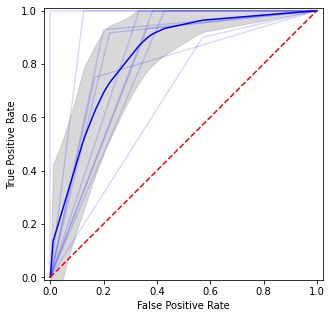

In [63]:
tprs = []
base_fpr = np.linspace(0, 1, 101)

plt.figure(figsize=(5, 5))

for i in range(10):
  train_labels = y_train.to_numpy() # train is statified so stratifying on train_labels should be stratified to whole set
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = i, test_size = 0.1, stratify = train_labels)
  
  X_val = X_val.reset_index(drop = True)
  y_val = y_val.reset_index(drop = True)

  clf = SVC(kernel = 'rbf', probability = True, class_weight = 'balanced', C = 100)
  clf.fit(X_train, y_train)

  y_pred = (clf.predict_proba(X_val)[:,1] >= thresh_arr[i]).astype(int) # optimal thresh is 0.59
  curr_acc = accuracy_score(y_val, y_pred)
  print(curr_acc)

  fpr, tpr, _ = roc_curve(y_val, y_pred)
  plt.plot(fpr, tpr, 'b', alpha=0.15)
  tpr = interp(base_fpr, fpr, tpr)
  tpr[0] = 0.0
  tprs.append(tpr)


tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std


plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.show()

## **Test Set Results**

In [64]:
clf = LogisticRegression(penalty='elasticnet', C = 0.01, class_weight='balanced', random_state = None, solver = 'saga', fit_intercept = True, l1_ratio = 0.5)
clf.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=0.5,
                   max_iter=100, multi_class='auto', n_jobs=None,
                   penalty='elasticnet', random_state=None, solver='saga',
                   tol=0.0001, verbose=0, warm_start=False)

In [65]:
thresholds = list(np.arange(0, 1, 0.01))

best_thresh_acc = 0.0
best_thresh = 0.0

for thresh in thresholds:
  threshold_pred = (clf.predict_proba(X_test)[:,1] >= thresh).astype(int)
  threshold_acc = accuracy_score(y_test, threshold_pred)

  if threshold_acc >= best_thresh_acc:
    best_thresh_acc = threshold_acc
    best_thresh = thresh

print(best_thresh, best_thresh_acc)

0.5 0.8775510204081632


In [66]:
y_pred = (clf.predict_proba(X_test)[:,1] >= best_thresh).astype(int)
y_probas = clf.predict_proba(X_test)[:,1]

In [67]:
roc_auc_score(y_test, y_probas)

0.8256777108433735

In [68]:
target_names = ['Control', 'PD']
results = classification_report(y_test, y_pred, target_names = target_names, output_dict=True)
results = pd.DataFrame(results).transpose()
conf_mat = confusion_matrix(y_test, y_pred)

In [69]:
conf_mat

array([[46, 18],
       [ 0, 83]])

In [70]:
TN, FP, FN, TP = conf_mat.ravel()

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)

print("TP: ", TP)
print("TN: ", TN)
print("FP: ", FP)
print("FN: ", FN)

print("Sensitivity: ", TPR)
print("Specificity: ", TNR)
print("NPV: ", NPV)
print("PPV: ", PPV)

TP:  83
TN:  46
FP:  18
FN:  0
Sensitivity:  1.0
Specificity:  0.71875
NPV:  1.0
PPV:  0.8217821782178217
